In [35]:
ROOT = pathlib.Path('Mewsli-9')

In [1]:
import pathlib
import glob
import json

import dawg
import tqdm
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

results = {}
for file in tqdm.tqdm(list(ROOT.glob('*.tsv'))):
    lang = file.stem
    index = glob.glob(f'../wiki/{lang}wiki-*/index_{lang}wiki-*.dawg')[0]
    wm = dawg.IntDAWG().load(index)
    
    cache = {}
    def predict(sent, surface, wm):
        ref = cache.setdefault(surface, wm.get( surface.replace(' ','_') ))
        return ref or -1

    surface, pred, gold = zip(*[
        (surface, predict(text, surface, wm), ref)
        for _, links, text in (l.split('\t') for l in file.open())
        for surface, ref in json.loads(links).items()
    ])

    res = pd.DataFrame({
        avg: precision_recall_fscore_support(gold, pred, zero_division=0, average=avg)[:-1]
        for avg in ['micro','macro']
    }, index=['precision', 'recall', 'fscore']).unstack().T
    res.loc[('', 'support')] = len(gold)
    results[lang] = res

(pd.DataFrame(results).T.sort_values(('','support'))[::-1]
 .style.bar(vmin=0, vmax=1, color='lightblue').format('{:.2f}')
 .set_caption('Wikipedia Page Name Baseline')
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


# Annotation problems

In [36]:
import pandas as pd
disambig = set(pd.read_csv('../data/wikidata-20211122-disambig.txt', header=None)[0])
listpage = set(pd.read_csv('../data/wikidata-20211122-list.txt', header=None)[0])

counts = {}
for file in tqdm.tqdm(list(ROOT.glob('*.tsv'))):
    lang = file.stem
    refs = [
        ref
        for _, links, text in (l.split('\t') for l in file.open())
        for surface, ref in json.loads(links).items()
    ]
    
    counts[lang] = {
        'disambig': sum(1 for r in refs if r in disambig),
        'listpage': sum(1 for r in refs if r in listpage),
        'total': len(refs),
    }
pd.DataFrame(counts)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.27it/s]


,en,ar,de,es,fa,ja,sr,ta,tr,nl
disambig,2751,201,1907,1923,5,605,773,28,164,565
listpage,259,4,76,105,0,54,7,1,5,16
total,79258,5964,64807,55431,515,34214,35536,2683,5661,11962


# Rank analysis

In [42]:
import json, re, html, pathlib
from collections import Counter

import matplotlib.pyplot as plt

from minimel.normalize import normalize, SNOWBALL_LANG
code_lang = dict(SNOWBALL_LANG)
code_lang['fa'] = 'Persian'
code_lang['ja'] = 'Japanese'

def rank(wm, counts, surface, i, stem=None):
    for norm in normalize(surface, language=stem):
        norm = norm.lower()
        ent_count = counts.get(norm, {})
        if len(ent_count) == 1 and ent_count.get('Q%s'%i):
            return ent_count['Q%s'%i], -1
        if ent_count.get('Q%s'%i):
            order = sorted(ent_count, key=lambda x: -ent_count[x])
            return ent_count['Q%s'%i], order.index('Q%s'%i)
    if wm.get(surface.replace(' ','_')) == i:
        return 1, -1
    return 0, None

total_counts = {}
ranks = {}
stem_ranks = {}
for file in tqdm.tqdm(list(ROOT.glob('*.tsv'))):
    lang = file.stem
    if lang not in ['ta','nl']:
        continue
    index = glob.glob(f'../wiki/{lang}wiki-*/index_{lang}wiki-*.dawg')[0]
    wm = dawg.IntDAWG().load(index)
    
    counttypes = []
    
    countfile = pathlib.Path(index).parent / 'count.min2.json'
    if not countfile.exists():
        continue
    counts = json.load(open(countfile))
    counttypes += [(counts, None, ranks)]
    
    stemfile = pathlib.Path(index).parent / f'count.min2.stem-{lang}.json'
    if not stemfile.exists():
        continue
    counttypes += [(json.load(open(countfile)), lang, stem_ranks)]
    
    total_counts[lang] = Counter()
    for ec in counts.values():
        for e,c in ec.items():
            total_counts[lang][int(e.replace('Q',''))] += c
    
    for c, stem, r in counttypes:
        r[lang] = pd.DataFrame([
            (surface, ref, *rank(wm, c, surface, ref, stem=stem))
            for _, links, text in (l.split('\t') for l in file.open())
            for surface, ref in json.loads(links).items()
            if ref not in disambig
        ], columns=['surface', 'ref', 'count', 'rank'])
len(ranks), len(stem_ranks)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


(2, 2)

(-0.5, 1.5)

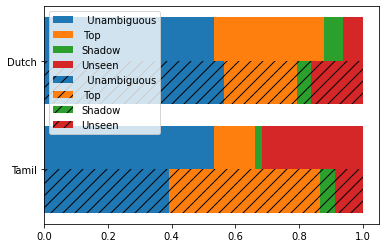

In [50]:
def cat(x):
    return 'Unseen' if pd.isna(x) else ('Shadow' if x>0 else (' Top' if x==0 else '  Unambiguous'))

fig, ax = plt.subplots()
pd.DataFrame({
    code_lang.get(l,l).title():r['rank'].apply(cat).value_counts() / len(r)
    for l,r in ranks.items()
}).sort_index().T.plot.barh(ax=ax, stacked=True, width=.4, position=0)
pd.DataFrame({
    code_lang.get(l,l).title():r['rank'].apply(cat).value_counts() / len(r)
    for l,r in stem_ranks.items()
}).sort_index().T.plot.barh(ax=ax, stacked=True, width=.4, position=1, hatch='//')
ax.set_ylim([-.5, len(ranks)-.5])

In [55]:
lang = 'nl'
r = ranks[lang]

In [63]:
# Unseen
r[r['count'] == 0].fillna(-1).value_counts().reset_index().head(20)

,surface,ref,count,rank,0
0,World Solar Challenge,14520244,0,-1.0,4
1,Nations League,29000951,0,-1.0,4
2,Abadi,5639013,0,-1.0,3
3,Trudeau,3099714,0,-1.0,3
4,Le Pen,12927,0,-1.0,3
5,en,4352982,0,-1.0,2
6,tsunami,60042839,0,-1.0,2
7,Team BMC,787401,0,-1.0,2
8,NPB,2113973,0,-1.0,2
9,Amerikaanse presidentschap,45578,0,-1.0,2


In [65]:
# Shadow
r[r['rank'] > 0].fillna(-1).value_counts().reset_index().head(20)

,surface,ref,count,rank,0
0,May,264766,15,2.0,6
1,Openbaar Ministerie,11775750,312,1.0,6
2,China,148,6406,1.0,5
3,Washington,61,1112,1.0,5
4,Peter Madsen,2076849,10,1.0,5
5,Amerikaanse presidentsverkiezingen,699872,17,2.0,5
6,ESM,1130098,30,1.0,5
7,Arriva,680991,245,1.0,4
8,Belastingdienst,2793644,168,1.0,4
9,Rabobank,252004,418,1.0,4


<AxesSubplot:>

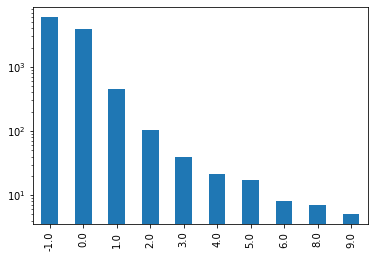

In [86]:
r['rank'].value_counts().head(10).plot.bar(logy=True)

In [95]:
len(total_counts['nl'])

1146616

In [104]:
clean = json.load(open('../wiki/nlwiki-20220301/count.min2.clean50000k2.json'))
# clean = json.load(open('../wiki/nlwiki-20220301/count.min2.clean10000k2.json'))
# clean = json.load(open('../wiki/nlwiki-20220301/count.min2.clean2500k2.json'))
# clean = json.load(open('../wiki/nlwiki-20220301/count.min2.clean1000.json'))
# clean = json.load(open('../wiki/nlwiki-20220301/count.min2.json'))
clean = set([(k,int(v.replace('Q',''))) for k, vs in clean.items() for v in vs])
shadow = set([(n,e) for s,e in r[r['rank'] > 0][['surface','ref']].values for n in normalize(s)])
top = set([(n,e) for s,e in r[r['rank'] == 0][['surface','ref']].values for n in normalize(s)])
print( len(clean), len(shadow), len(shadow & clean) )
print( len(clean), len(top), len(top & clean) )
# shadow - clean

100000 546 294
100000 2002 1171


{('a matter of time', 50330204),
 ('a.i.', 11660),
 ('a6', 758718),
 ('a7', 1814381),
 ('albany', 285599),
 ('alliance', 1318719),
 ('amazonegebied', 177567),
 ('amerikaanse', 11211),
 ('anc', 2860914),
 ('anjozorobe', 2850269),
 ('apache', 29561664),
 ('apex', 1122219),
 ('astrid', 27847759),
 ('atv', 2835676),
 ('automatische', 5778278),
 ('baldwin', 1132790),
 ('basisscholen', 9842),
 ('bellevue', 2310137),
 ('bijzondere gemeente', 3237519),
 ('blokker', 884934),
 ('boek', 950158),
 ('bos', 554127),
 ('bot', 191865),
 ('bourbon', 543127),
 ('bristol', 755149),
 ('brit', 842438),
 ('bruins', 2212796),
 ('buma', 377266),
 ('burgeroorlog', 2002975),
 ('burgeroorlog', 19686631),
 ('bus', 2650375),
 ('caf', 838212),
 ('cartoons', 627603),
 ('centrum', 2101377),
 ('charkov', 170666),
 ('chinees', 8201),
 ('chora', 2720579),
 ('cm', 2797711),
 ('coevorden', 2718628),
 ('columbus', 155935),
 ('condor', 312517),
 ('congress', 11268),
 ('daniel martin', 410678),
 ('de bilt', 516346),
 ('dead 

<AxesSubplot:>

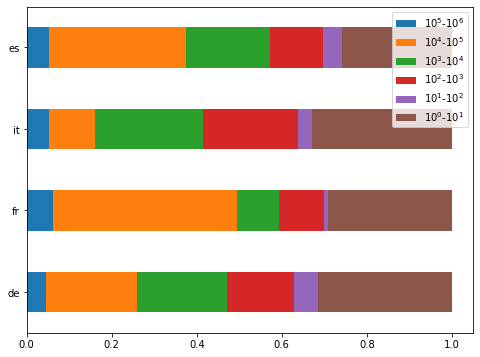

In [102]:
from numpy import log10
def freq_bins(l, r):
    return (
        r.merge(pd.Series(total_counts[l]).rename('total'), left_on='ref', right_index=True, how='left')['total'].fillna(1)
        .apply(lambda x: f'$10^{int(log10(x))}$-$10^{int(log10(x)+1)}$').value_counts()
    )
pd.DataFrame({
    l:freq_bins(l, r) / len(r)
    for l,r in ranks.items()
})[::-1].T.plot.barh(stacked=True, figsize=(8,6))